In [90]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
from scipy.signal import freqz
from Python_StartFiles import file_parser as fp
from Python_StartFiles import *
import math
import os

N: 16000
e max: 0.6554990162516625
e min: -0.7424112171702972
s max: 4.809993581457396
s min: -4.755477371657211
a_max: 1.9136044251471493
a_min: 1.0


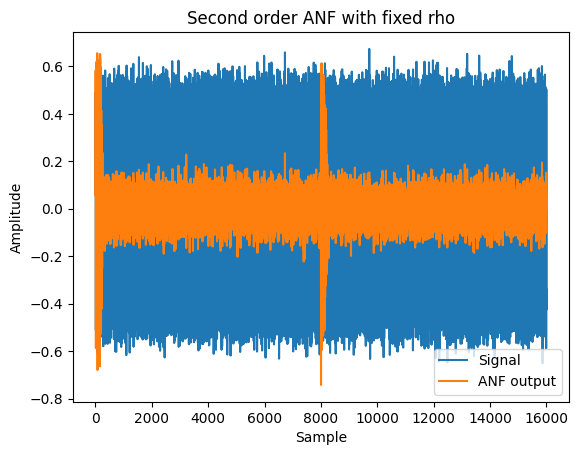

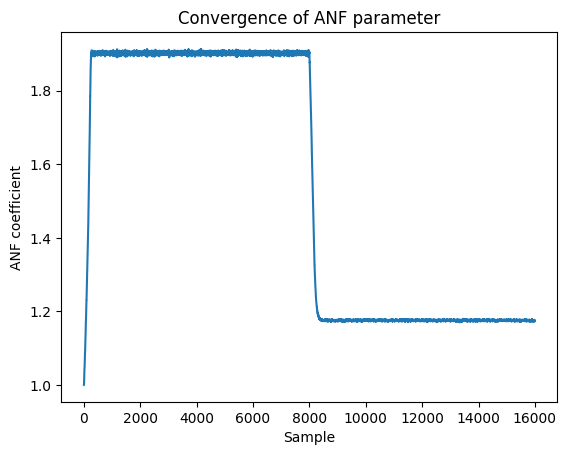

In [91]:
write_to_file_flag = True  # Flag to write input signal to file

##############################################################################
# Input signal creation
##############################################################################
fs = 8000  # Sampling frequency
freqs = [400, 1200]  # Frequencies to filter out

t = np.arange(0, fs) / fs  # Time vector
amplitude = 0.5  # Amplitude of input signal

# Create input signal
signal = amplitude * np.concatenate(
    ((np.sin(2 * np.pi * freqs[0] * t), np.sin(2 * np.pi * freqs[1] * t))))

N = len(signal)  # Number of samples in signal
print("N:", N)

# Add noise to input signal
stdev = 0.05
noise = np.random.normal(0, stdev, N)  # Noise vector
signal = signal + noise  # Noisy signal

##############################################################################
# Simulation of adaptive notch filter (ANF) with fixed rho
##############################################################################

# Initializations
e = np.zeros(N)  # ANF output signal vector
s = np.zeros(3)  # ANF state vector
a = np.zeros(N)  # ANF coefficient vector (for debugging only)

a_i = 1  # initialization of ANF parameter
rho = 0.8  # fixed rho
mu = 2 * 100 / (2 ** 15)  # 2 * mu
s_list =[]
e_list = []
a_list = []

# Simulation loop (iterations over time)
for i in range(N):
    s[2] = s[1]
    s[1] = s[0]
    s[0] = signal[i] + rho * a_i * s[1] - (rho ** 2) * s[2]
    s_list.append(s[0])
    e[i] = s[0] - a_i * s[1] + s[2]
    e_list.append(e[i])
    a_i = a_i + 2 * mu * s[1] * e[i]
    a[i] = a_i
    a_list.append(a_i)

##############################################################################
# print the max and min
##############################################################################
print("e max:", max(e_list))
print("e min:", min(e_list))
print("s max:", max(s_list))
print("s min:", min(s_list))
print("a_max:", max(a_list))
print("a_min:",min(a_list))

##############################################################################
# e Qm,n => Q1,15 signed 1 bit, 0 bit integer, 15 bit fraction
# s Qm,n => Q3,13 signed 1 bit, 3 bit integer, 11 bit fraction
# a Qm,n => Q1,15 signed 1 bit, 1 bit integer, 14 bit fraction

# Plot results
plt.figure()
plt.plot(signal)
plt.plot(e)
plt.title('Second order ANF with fixed rho')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend(['Signal', 'ANF output'])

# Plot convergence of ANF parameter
plt.figure()
plt.plot(a)
plt.title('Convergence of ANF parameter')
plt.xlabel('Sample')
plt.ylabel('ANF coefficient')
plt.show()

##############################################################################
# Write input signal to file
##############################################################################
if write_to_file_flag:
    q = 15
    signal_q = (signal * (2 ** q)).astype(np.int16)
    datapath = 'input.pcm'
    fp.writes(signal_q, datapath)

##############################################################################
# N: 16000
# e max: 0.6497141480870392
# e min: -0.7692424661069002
# s max: 4.764717115836087
# s min: -4.850967456298804
# a_max: 1.9082519038068326
# a_min: 0.9999945893609561
##############################################################################

### Q Factor for 400Hz

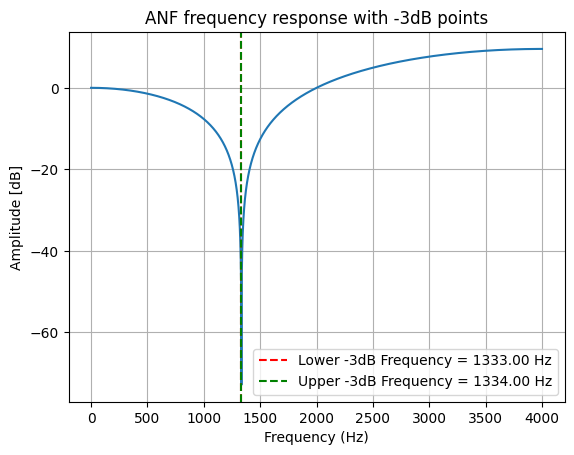

Lower -3dB Frequency: 1333.0 Hz
Upper -3dB Frequency: 1334.0000000000002 Hz
3dB Bandwidth: 1.0000000000002274 Hz
Q Factor: 399.99999999990905


In [92]:
import numpy as np
from scipy.signal import freqz
import matplotlib.pyplot as plt

# Given values
fs = 8000  # Sampling frequency
a_i = 1  # Initialization of ANF parameter
rho = 0.8  # Fixed rho

# Bode plot of ANF
w, h = freqz([1, -a_i, 1], worN=fs)

# Convert to dB
h_dB = 20 * np.log10(abs(h))

# Find the index of the minimum value in the response (deepest notch)
min_index = np.argmin(h_dB)

# Find the frequencies where the response is 3dB above the minimum
indices_3dB = np.where(h_dB >= h_dB[min_index] + 3)[0]

# Find the closest indices to the notch frequency
lower_index = indices_3dB[indices_3dB < min_index][-1]
upper_index = indices_3dB[indices_3dB > min_index][0]

# Convert indices to real frequencies
lower_freq = w[lower_index] * fs / (2 * np.pi)
upper_freq = w[upper_index] * fs / (2 * np.pi)

# Calculate 3dB bandwidth
bandwidth_3dB = upper_freq - lower_freq

# Assuming the center frequency is known (e.g., 400 Hz or 1200 Hz)
center_frequency = 400  # Adjusted to the visible notch in the provided plot

# Calculate Q factor
Q_factor = center_frequency / bandwidth_3dB

# Plot frequency response with the 3dB frequencies marked
plt.figure()
plt.plot(w * fs / (2 * np.pi), h_dB)  # Convert w to Hz for the x-axis
plt.axvline(x=lower_freq, color='r', linestyle='--', label=f'Lower -3dB Frequency = {lower_freq:.2f} Hz')
plt.axvline(x=upper_freq, color='g', linestyle='--', label=f'Upper -3dB Frequency = {upper_freq:.2f} Hz')
plt.title('ANF frequency response with -3dB points')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.grid(True)
plt.show()

print("Lower -3dB Frequency:", lower_freq, "Hz")
print("Upper -3dB Frequency:", upper_freq, "Hz")
print("3dB Bandwidth:", bandwidth_3dB, "Hz")
print("Q Factor:", Q_factor)


### Q Factor fro 1200 Hz

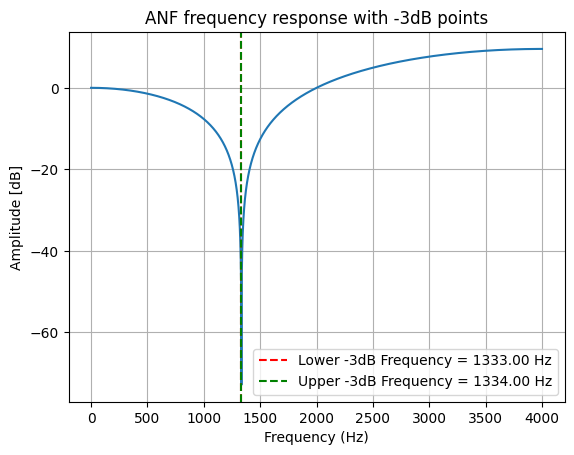

Lower -3dB Frequency: 1333.0 Hz
Upper -3dB Frequency: 1334.0000000000002 Hz
3dB Bandwidth: 1.0000000000002274 Hz
Q Factor: 1199.9999999997272


In [93]:
import numpy as np
from scipy.signal import freqz
import matplotlib.pyplot as plt

# Given values
fs = 8000  # Sampling frequency
a_i = 1  # Initialization of ANF parameter
rho = 0.8  # Fixed rho

# Bode plot of ANF
w, h = freqz([1, -a_i, 1], worN=fs)

# Convert to dB
h_dB = 20 * np.log10(abs(h))

# Find the index of the minimum value in the response (deepest notch)
min_index = np.argmin(h_dB)

# Find the frequencies where the response is 3dB above the minimum
indices_3dB = np.where(h_dB >= h_dB[min_index] + 3)[0]

# Find the closest indices to the notch frequency
lower_index = indices_3dB[indices_3dB < min_index][-1]
upper_index = indices_3dB[indices_3dB > min_index][0]

# Convert indices to real frequencies
lower_freq = w[lower_index] * fs / (2 * np.pi)
upper_freq = w[upper_index] * fs / (2 * np.pi)

# Calculate 3dB bandwidth
bandwidth_3dB = upper_freq - lower_freq

# Assuming the center frequency is known (e.g., 400 Hz or 1200 Hz)
center_frequency = 1200  # Adjusted to the visible notch in the provided plot

# Calculate Q factor
Q_factor = center_frequency / bandwidth_3dB

# Plot frequency response with the 3dB frequencies marked
plt.figure()
plt.plot(w * fs / (2 * np.pi), h_dB)  # Convert w to Hz for the x-axis
plt.axvline(x=lower_freq, color='r', linestyle='--', label=f'Lower -3dB Frequency = {lower_freq:.2f} Hz')
plt.axvline(x=upper_freq, color='g', linestyle='--', label=f'Upper -3dB Frequency = {upper_freq:.2f} Hz')
plt.title('ANF frequency response with -3dB points')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.grid(True)
plt.show()

print("Lower -3dB Frequency:", lower_freq, "Hz")
print("Upper -3dB Frequency:", upper_freq, "Hz")
print("3dB Bandwidth:", bandwidth_3dB, "Hz")
print("Q Factor:", Q_factor)


### Helper to convert the floatign point value to hexademical value

In [94]:
# Re-executing the code to convert the floating-point value 0.8 to fixed-point 16q16 and then to hexadecimal
rho_float = 0.8
rho_fixed_point = int(rho_float * (2 ** 16))
rho_fix = rho_fixed_point
rho_hex = format(rho_fixed_point, 'X')
print("rho float:", rho_fix)
print("rho float in hex:", rho_hex)

mu_hex = format(int(mu * (2 ** 16)), 'X')
print("mu float:", int(mu * (2 ** 16)))
print("mu float in hex:", mu_hex)

lambda_float = 0.6
lambda_point = int(lambda_float * (2 ** 15))
lambda_hex = format(lambda_point, 'X')
print("lambda float:", lambda_point)
print("lambda float in hex:", lambda_hex)

lambda2_float = 1 - lambda_float
lambda2_point = int(lambda2_float * (2 ** 15))
lambda2_hex = format(lambda2_point, 'X')

print("minus_lambda float:", lambda2_point)
print("minus_lambda float in hex:", lambda2_hex)

a_max_abs_float = 1.99
a_max_abs_fixed = int(a_max_abs_float * (2 ** 14))
a_max_abs_hex = format(a_max_abs_fixed, 'X')
print("a_max_abs_fixed:", a_max_abs_fixed)
print("a_max_abs_hex", a_max_abs_hex)


rho float: 52428
rho float in hex: CCCC
mu float: 400
mu float in hex: 190
lambda float: 19660
lambda float in hex: 4CCC
minus_lambda float: 13107
minus_lambda float in hex: 3333
a_max_abs_fixed: 32604
a_max_abs_hex 7F5C


In [95]:
import os
import numpy as np


# Write data to file
def writes(data, datapath):
    # check that data only contains integers
    if not np.issubdtype(data.dtype, np.integer):
        raise ValueError('data must be integer type')

    if not np.issubdtype(data.dtype, np.int16):
        data = data.astype(np.int16)

    # check that data is 1D
    if data.ndim != 1:
        raise ValueError('data must be 1D')

    # write data to file in Little-endian ordering
    with open(datapath, 'wb') as f:
        data.tofile(f)


# Read data from file
def reads(datapath):
    # check that file exists
    if not os.path.isfile(datapath):
        raise ValueError('file does not exist')

    # read data from file in Little-endian ordering
    with open(datapath, 'rb') as f:
        data = np.fromfile(f, dtype=np.int16)
    return data


### Input frequency response: narrow band 400Hz and 1200 Hz
with found:
- N: 16000
- e max: 0.6554990162516625
- e min: -0.7424112171702972
- s max: 4.809993581457396
- s min: -4.755477371657211
- a_max: 1.9136044251471493
- a_min: 1.0
hence q format:
- rho => always smaller than 1 and larger-or-equal to 0 => 16q16 => use all fraction bits and is unsigned short
- mu => given => 16q15
- lambda => 16q15
- a => always positive but smaller than 2 => unsigned short 16q15 => 1 bit for integer, no bit for sign
- e => signed short and smaller than 1 => 16q15
- s => signed short and absolute value smaller than 5 => 16q11 => 1 bit for signed, 3 bit for integer


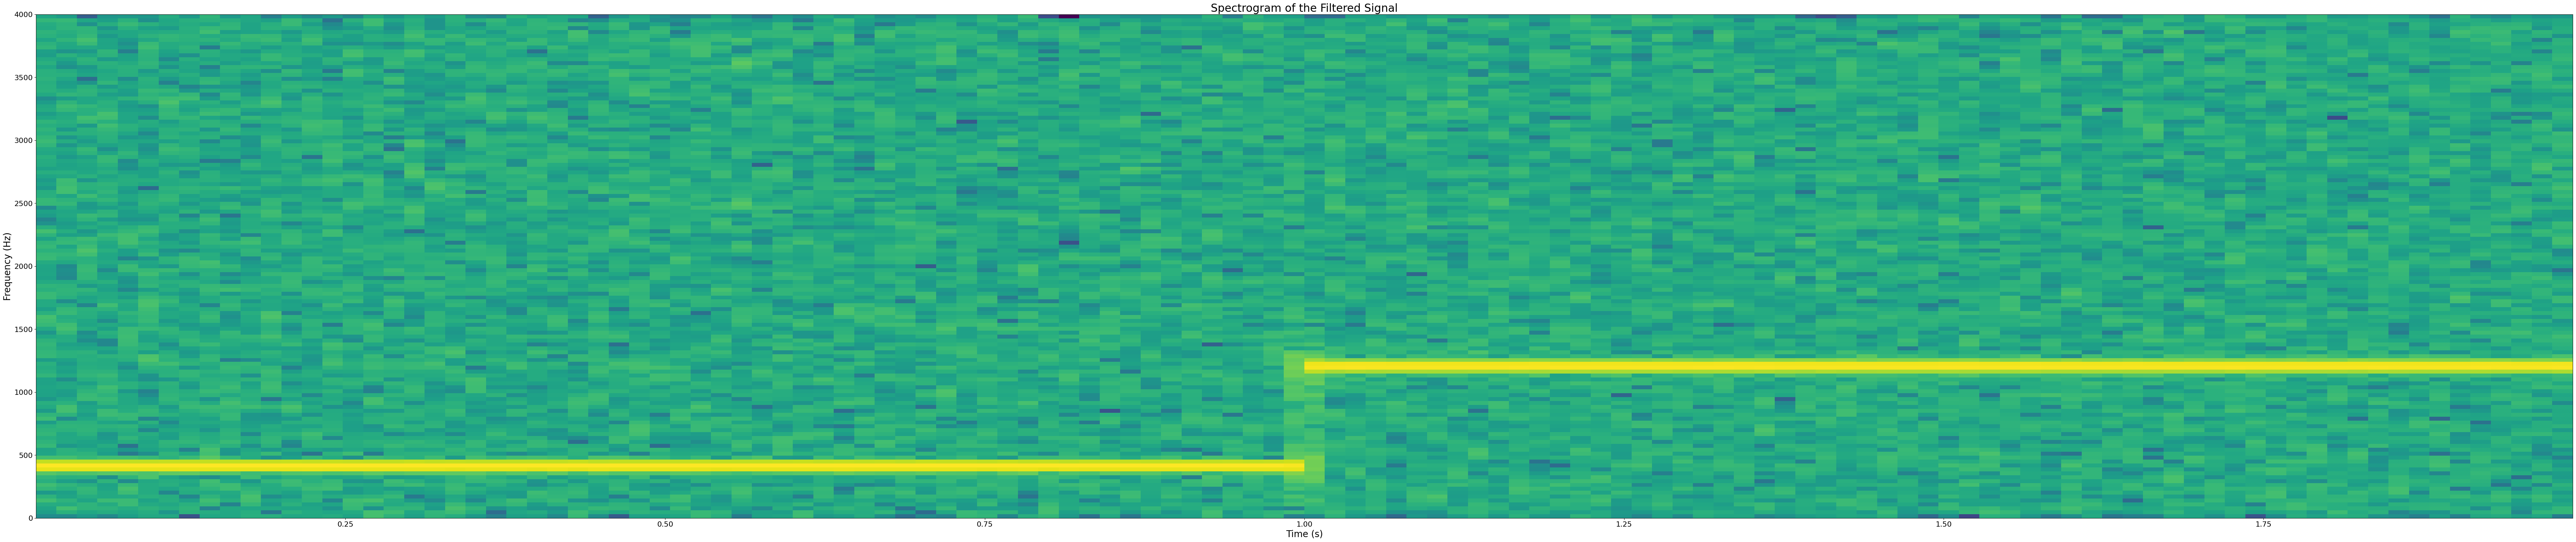

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


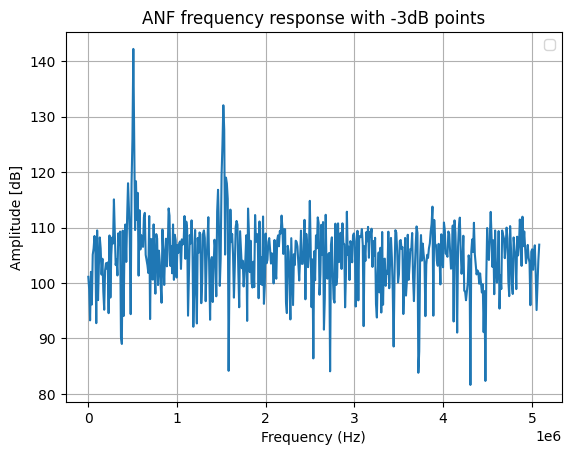

Lower -3dB Frequency: 216.00000000000006 Hz
Upper -3dB Frequency: 217.0 Hz
3dB Bandwidth: 0.9999999999999432 Hz
Q Factor: 1200.0000000000682


In [101]:
anfData = reads("input.pcm")

# Plot a spectrogram and magnitude plot of the filtered signal
plt.figure(figsize=(100, 20))
plt.specgram(anfData, Fs=fs)
plt.xlabel('Time (s)', fontsize=20)  # Set the fontsize for x-axis label
plt.ylabel('Frequency (Hz)', fontsize=20)  # Set the fontsize for y-axis label
plt.title('Spectrogram of the Filtered Signal', fontsize=24)  # Set the fontsize for title
plt.tick_params(axis='both', which='major', labelsize=16)  # Set the fontsize for the tick labels on both axes
plt.show()

# plot the magnitude spectrum of the filtered signal using signal.freqz
w_y, h_y = sp.signal.freqz(anfData, fs = fs)
h_y_dB = 20 * np.log10(abs(h_y));


# Find the index of the minimum value in the response (deepest notch)
min_index = np.argmin(h_y_dB)

# Find the frequencies where the response is 3dB above the minimum
indices_3dB = np.where(h_y_dB >= h_y_dB[min_index] + 3)[0]

# Find the closest indices to the notch frequency
lower_index = indices_3dB[indices_3dB < min_index][-1]
upper_index = indices_3dB[indices_3dB > min_index][0]

# Convert indices to real frequencies
lower_freq = w[lower_index] * fs / (2 * np.pi)
upper_freq = w[upper_index] * fs / (2 * np.pi)

# Calculate 3dB bandwidth
bandwidth_3dB = upper_freq - lower_freq

# Assuming the center frequency is known (e.g., 400 Hz or 1200 Hz)
center_frequency = 1200  # Adjusted to the visible notch in the provided plot

# Calculate Q factor
Q_factor = center_frequency / bandwidth_3dB

# Plot frequency response with the 3dB frequencies marked
plt.figure()
plt.plot(w_y * fs / (2 * np.pi), h_y_dB)  # Convert w to Hz for the x-axis
# plt.axvline(x=lower_freq, color='r', linestyle='--', label=f'Lower -3dB Frequency = {lower_freq:.2f} Hz')
# plt.axvline(x=upper_freq, color='g', linestyle='--', label=f'Upper -3dB Frequency = {upper_freq:.2f} Hz')
plt.title('ANF frequency response with -3dB points')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.grid(True)
plt.show()

print("Lower -3dB Frequency:", lower_freq, "Hz")
print("Upper -3dB Frequency:", upper_freq, "Hz")
print("3dB Bandwidth:", bandwidth_3dB, "Hz")
print("Q Factor:", Q_factor)


### Assembly with lambda = 0.6 and Gain 10dB
frequency response shows 400 and 1200 Hz removed

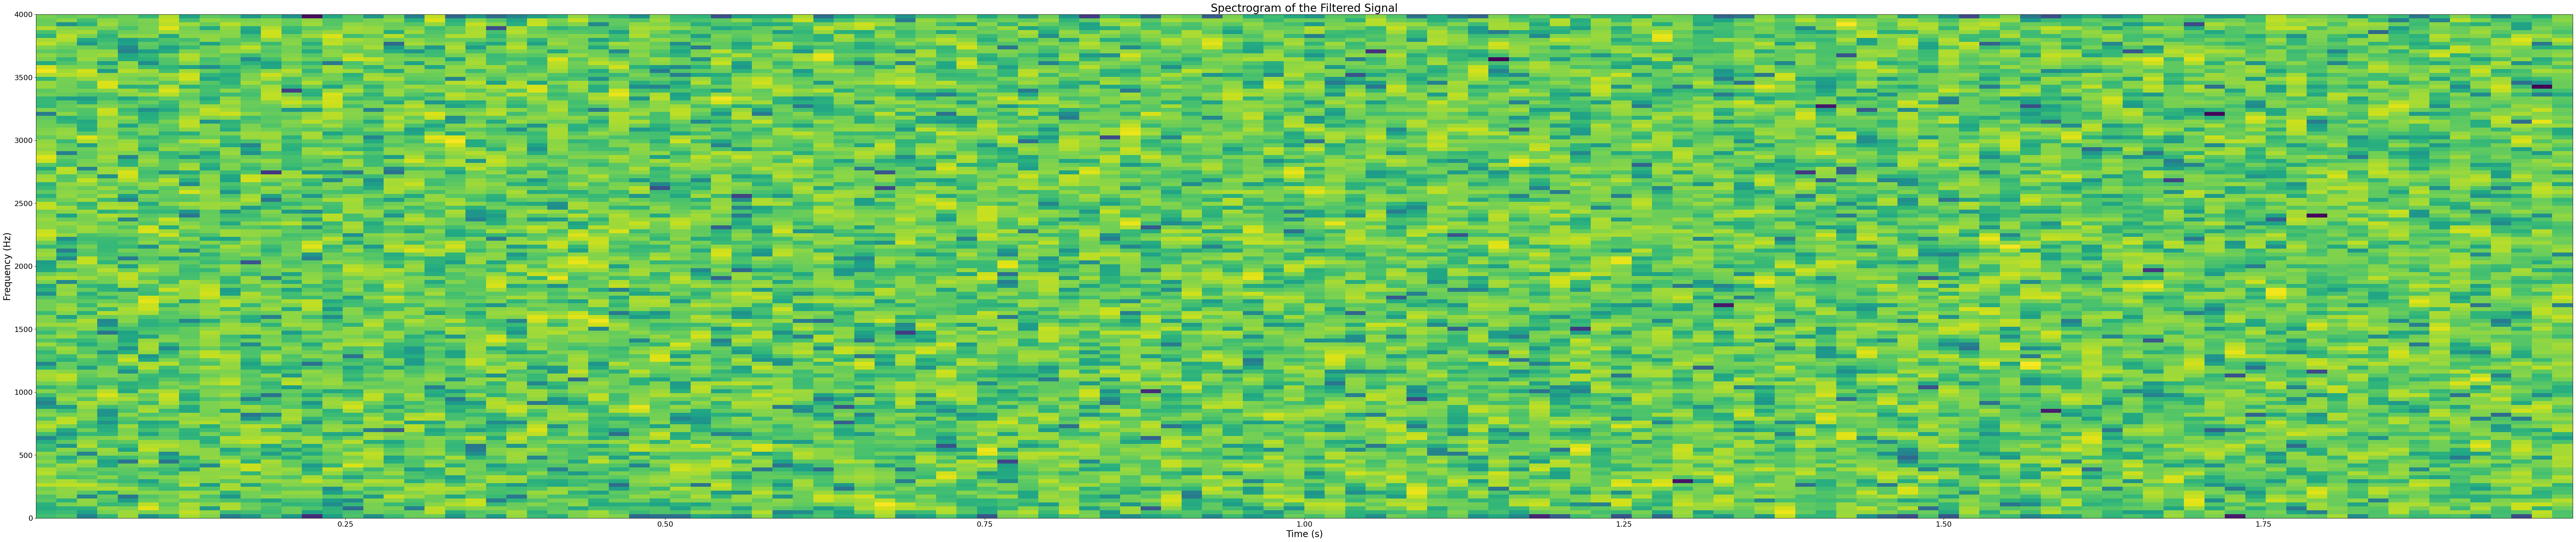

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


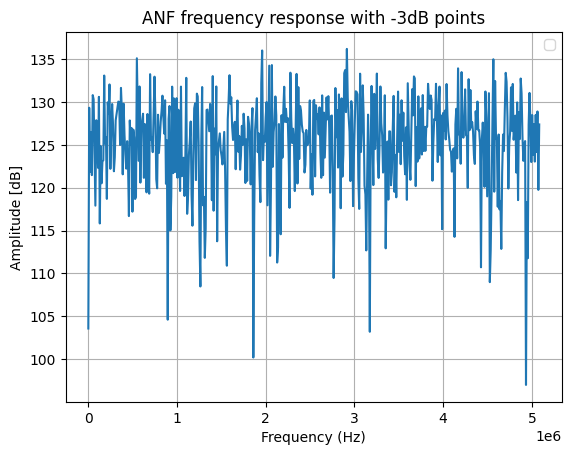

Lower -3dB Frequency: 247.5 Hz
Upper -3dB Frequency: 248.5 Hz
3dB Bandwidth: 1.0 Hz
Q Factor: 1200.0


In [102]:
anfData = reads("output_off_assy_test.pcm")

# Plot a spectrogram and magnitude plot of the filtered signal
plt.figure(figsize=(100, 20))
plt.specgram(anfData, Fs=fs)
plt.xlabel('Time (s)', fontsize=20)  # Set the fontsize for x-axis label
plt.ylabel('Frequency (Hz)', fontsize=20)  # Set the fontsize for y-axis label
plt.title('Spectrogram of the Filtered Signal', fontsize=24)  # Set the fontsize for title
plt.tick_params(axis='both', which='major', labelsize=16)  # Set the fontsize for the tick labels on both axes
plt.show()

# plot the magnitude spectrum of the filtered signal using signal.freqz
w_y, h_y = sp.signal.freqz(anfData, fs = fs)
h_y_dB = 20 * np.log10(abs(h_y));


# Find the index of the minimum value in the response (deepest notch)
min_index = np.argmin(h_y_dB)

# Find the frequencies where the response is 3dB above the minimum
indices_3dB = np.where(h_y_dB >= h_y_dB[min_index] + 3)[0]

# Find the closest indices to the notch frequency
lower_index = indices_3dB[indices_3dB < min_index][-1]
upper_index = indices_3dB[indices_3dB > min_index][0]

# Convert indices to real frequencies
lower_freq = w[lower_index] * fs / (2 * np.pi)
upper_freq = w[upper_index] * fs / (2 * np.pi)

# Calculate 3dB bandwidth
bandwidth_3dB = upper_freq - lower_freq

# Assuming the center frequency is known (e.g., 400 Hz or 1200 Hz)
center_frequency = 1200  # Adjusted to the visible notch in the provided plot

# Calculate Q factor
Q_factor = center_frequency / bandwidth_3dB

# Plot frequency response with the 3dB frequencies marked
plt.figure()
plt.plot(w_y * fs / (2 * np.pi), h_y_dB)  # Convert w to Hz for the x-axis
# plt.axvline(x=lower_freq, color='r', linestyle='--', label=f'Lower -3dB Frequency = {lower_freq:.2f} Hz')
# plt.axvline(x=upper_freq, color='g', linestyle='--', label=f'Upper -3dB Frequency = {upper_freq:.2f} Hz')
plt.title('ANF frequency response with -3dB points')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.grid(True)
plt.show()

print("Lower -3dB Frequency:", lower_freq, "Hz")
print("Upper -3dB Frequency:", upper_freq, "Hz")
print("3dB Bandwidth:", bandwidth_3dB, "Hz")
print("Q Factor:", Q_factor)


### C with lambda = 0.6 and gain 10dB
frequency response shows 400 and 1200 Hz removed

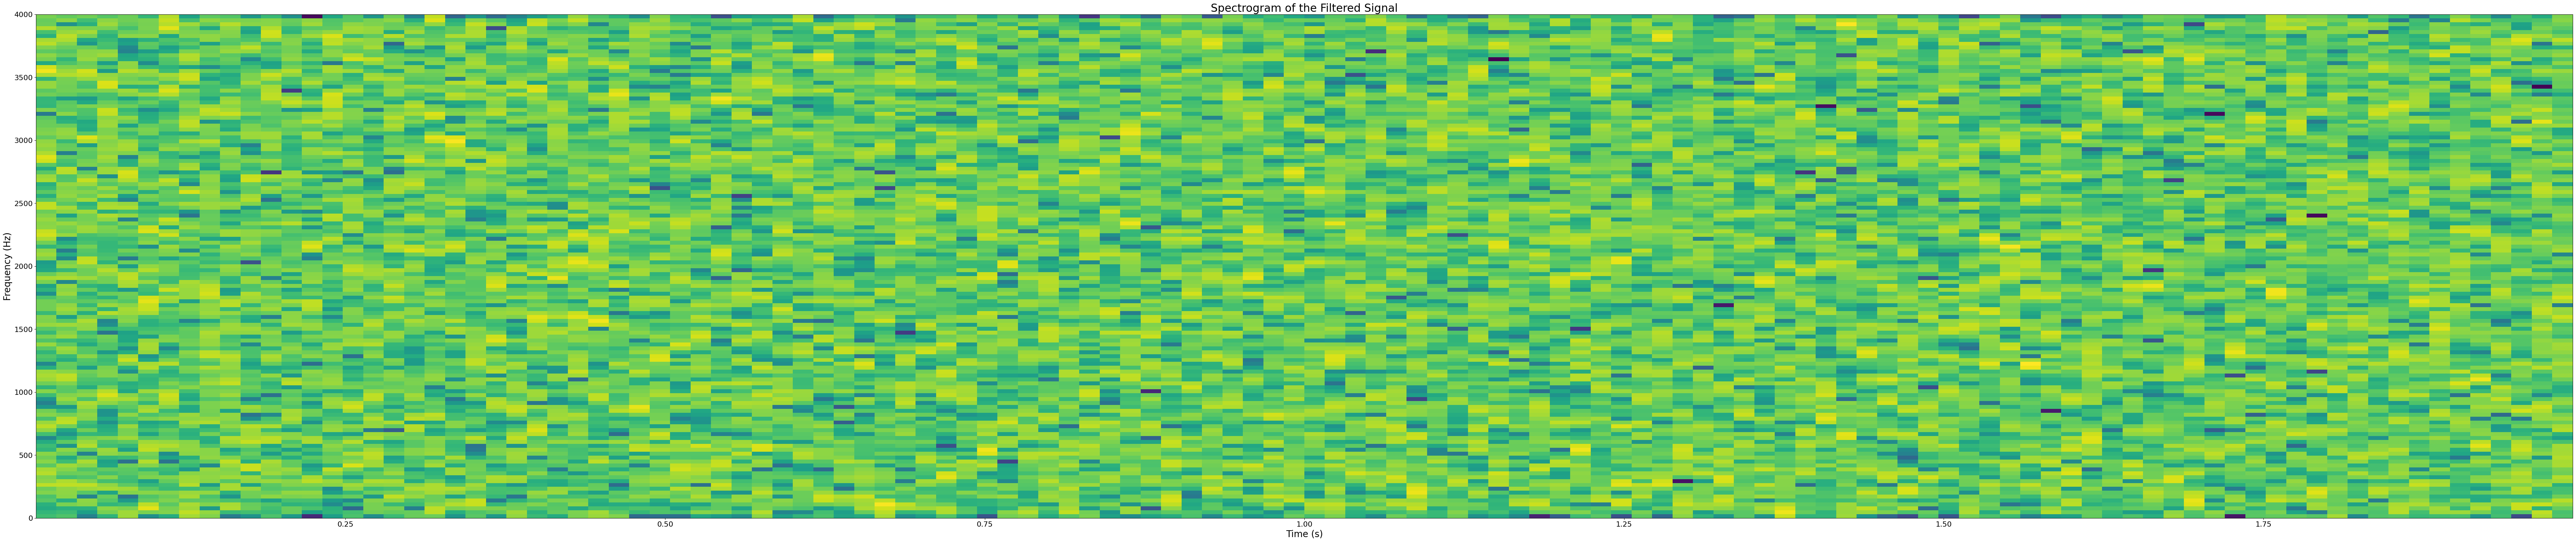

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


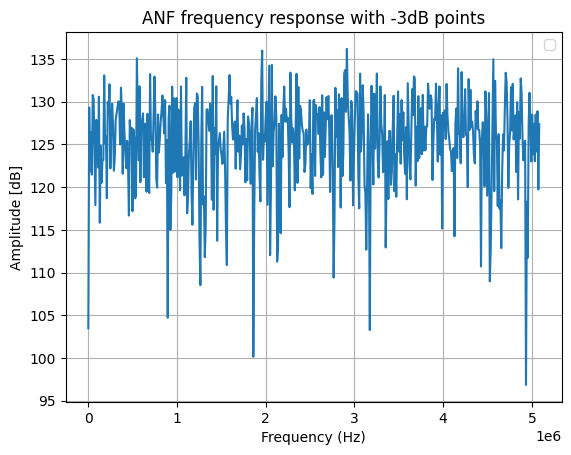

Lower -3dB Frequency: 247.5 Hz
Upper -3dB Frequency: 248.5 Hz
3dB Bandwidth: 1.0 Hz
Q Factor: 1200.0


In [103]:
anfData = reads("output_off_c_test.pcm")

# Plot a spectrogram and magnitude plot of the filtered signal
plt.figure(figsize=(100, 20))
plt.specgram(anfData, Fs=fs)
plt.xlabel('Time (s)', fontsize=20)  # Set the fontsize for x-axis label
plt.ylabel('Frequency (Hz)', fontsize=20)  # Set the fontsize for y-axis label
plt.title('Spectrogram of the Filtered Signal', fontsize=24)  # Set the fontsize for title
plt.tick_params(axis='both', which='major', labelsize=16)  # Set the fontsize for the tick labels on both axes
plt.show()

# plot the magnitude spectrum of the filtered signal using signal.freqz
w_y, h_y = sp.signal.freqz(anfData, fs = fs)
h_y_dB = 20 * np.log10(abs(h_y));


# Find the index of the minimum value in the response (deepest notch)
min_index = np.argmin(h_y_dB)

# Find the frequencies where the response is 3dB above the minimum
indices_3dB = np.where(h_y_dB >= h_y_dB[min_index] + 3)[0]

# Find the closest indices to the notch frequency
lower_index = indices_3dB[indices_3dB < min_index][-1]
upper_index = indices_3dB[indices_3dB > min_index][0]

# Convert indices to real frequencies
lower_freq = w[lower_index] * fs / (2 * np.pi)
upper_freq = w[upper_index] * fs / (2 * np.pi)

# Calculate 3dB bandwidth
bandwidth_3dB = upper_freq - lower_freq

# Assuming the center frequency is known (e.g., 400 Hz or 1200 Hz)
center_frequency = 1200  # Adjusted to the visible notch in the provided plot

# Calculate Q factor
Q_factor = center_frequency / bandwidth_3dB

# Plot frequency response with the 3dB frequencies marked
plt.figure()
plt.plot(w_y * fs / (2 * np.pi), h_y_dB)  # Convert w to Hz for the x-axis
# plt.axvline(x=lower_freq, color='r', linestyle='--', label=f'Lower -3dB Frequency = {lower_freq:.2f} Hz')
# plt.axvline(x=upper_freq, color='g', linestyle='--', label=f'Upper -3dB Frequency = {upper_freq:.2f} Hz')
plt.title('ANF frequency response with -3dB points')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.grid(True)
plt.show()

print("Lower -3dB Frequency:", lower_freq, "Hz")
print("Upper -3dB Frequency:", upper_freq, "Hz")
print("3dB Bandwidth:", bandwidth_3dB, "Hz")
print("Q Factor:", Q_factor)


### Assembly with lambda = 0.9 and gain 10dB
frequency response shows 400 and 1200 Hz removed

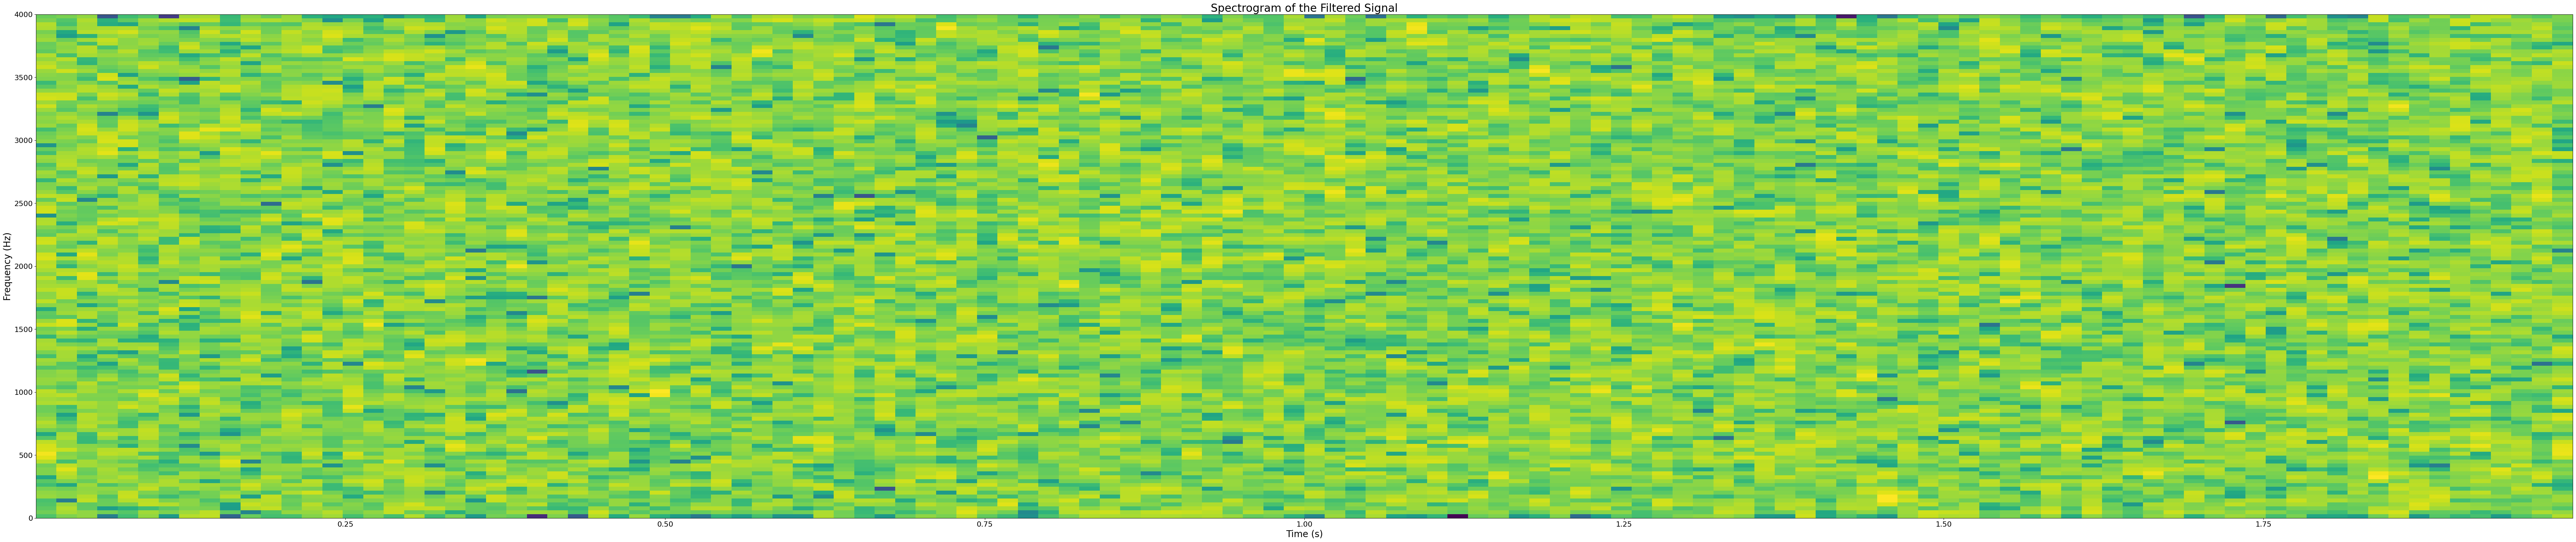

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


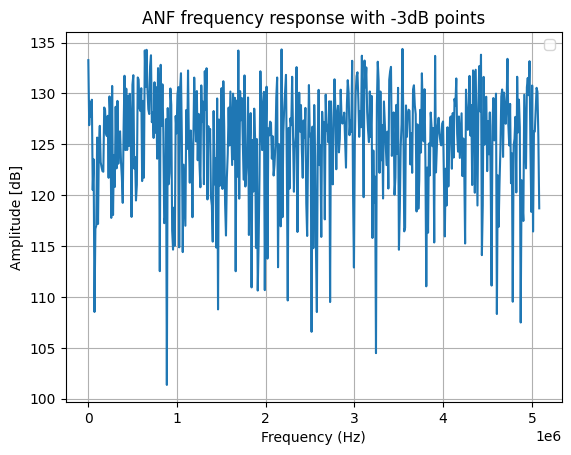

Lower -3dB Frequency: 44.00000000000001 Hz
Upper -3dB Frequency: 45.0 Hz
3dB Bandwidth: 0.9999999999999929 Hz
Q Factor: 1200.0000000000086


In [104]:
anfData = reads("output_off_assy_test_9Lambda.pcm")

# Plot a spectrogram and magnitude plot of the filtered signal
plt.figure(figsize=(100, 20))
plt.specgram(anfData, Fs=fs)
plt.xlabel('Time (s)', fontsize=20)  # Set the fontsize for x-axis label
plt.ylabel('Frequency (Hz)', fontsize=20)  # Set the fontsize for y-axis label
plt.title('Spectrogram of the Filtered Signal', fontsize=24)  # Set the fontsize for title
plt.tick_params(axis='both', which='major', labelsize=16)  # Set the fontsize for the tick labels on both axes
plt.show()

# plot the magnitude spectrum of the filtered signal using signal.freqz
w_y, h_y = sp.signal.freqz(anfData, fs = fs)
h_y_dB = 20 * np.log10(abs(h_y));


# Find the index of the minimum value in the response (deepest notch)
min_index = np.argmin(h_y_dB)

# Find the frequencies where the response is 3dB above the minimum
indices_3dB = np.where(h_y_dB >= h_y_dB[min_index] + 3)[0]

# Find the closest indices to the notch frequency
lower_index = indices_3dB[indices_3dB < min_index][-1]
upper_index = indices_3dB[indices_3dB > min_index][0]

# Convert indices to real frequencies
lower_freq = w[lower_index] * fs / (2 * np.pi)
upper_freq = w[upper_index] * fs / (2 * np.pi)

# Calculate 3dB bandwidth
bandwidth_3dB = upper_freq - lower_freq

# Assuming the center frequency is known (e.g., 400 Hz or 1200 Hz)
center_frequency = 1200  # Adjusted to the visible notch in the provided plot

# Calculate Q factor
Q_factor = center_frequency / bandwidth_3dB

# Plot frequency response with the 3dB frequencies marked
plt.figure()
plt.plot(w_y * fs / (2 * np.pi), h_y_dB)  # Convert w to Hz for the x-axis
# plt.axvline(x=lower_freq, color='r', linestyle='--', label=f'Lower -3dB Frequency = {lower_freq:.2f} Hz')
# plt.axvline(x=upper_freq, color='g', linestyle='--', label=f'Upper -3dB Frequency = {upper_freq:.2f} Hz')
plt.title('ANF frequency response with -3dB points')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.grid(True)
plt.show()

print("Lower -3dB Frequency:", lower_freq, "Hz")
print("Upper -3dB Frequency:", upper_freq, "Hz")
print("3dB Bandwidth:", bandwidth_3dB, "Hz")
print("Q Factor:", Q_factor)


### C with lambda = 0.9 and gain 10dB
frequency response shows 400 and 1200 Hz removed

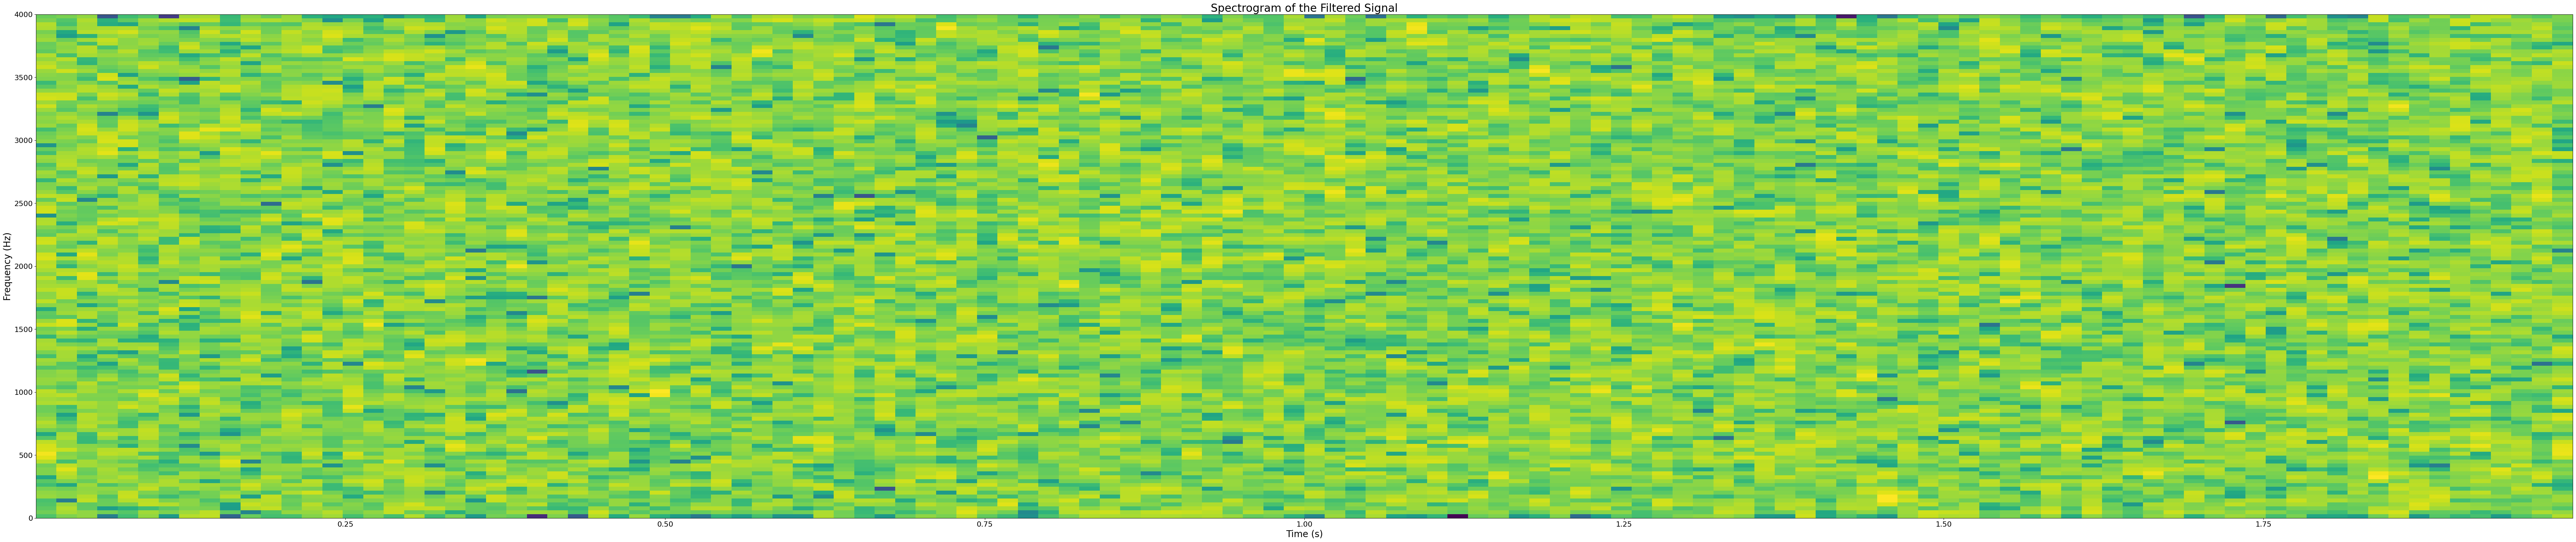

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


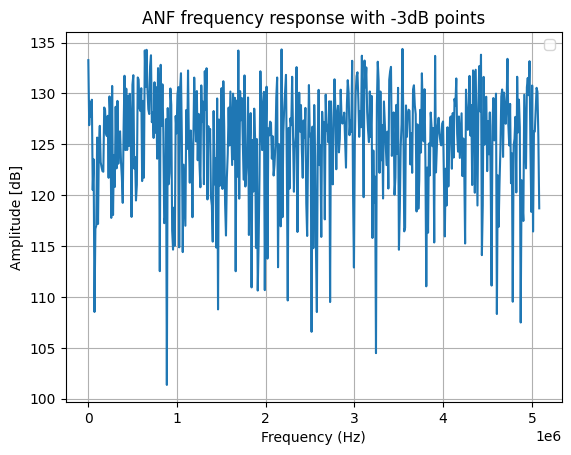

Lower -3dB Frequency: 44.00000000000001 Hz
Upper -3dB Frequency: 45.0 Hz
3dB Bandwidth: 0.9999999999999929 Hz
Q Factor: 1200.0000000000086


In [105]:
anfData = reads("output_off_c_test_9Lambda.pcm")

# Plot a spectrogram and magnitude plot of the filtered signal
plt.figure(figsize=(100, 20))
plt.specgram(anfData, Fs=fs)
plt.xlabel('Time (s)', fontsize=20)  # Set the fontsize for x-axis label
plt.ylabel('Frequency (Hz)', fontsize=20)  # Set the fontsize for y-axis label
plt.title('Spectrogram of the Filtered Signal', fontsize=24)  # Set the fontsize for title
plt.tick_params(axis='both', which='major', labelsize=16)  # Set the fontsize for the tick labels on both axes
plt.show()

# plot the magnitude spectrum of the filtered signal using signal.freqz
w_y, h_y = sp.signal.freqz(anfData, fs = fs)
h_y_dB = 20 * np.log10(abs(h_y));


# Find the index of the minimum value in the response (deepest notch)
min_index = np.argmin(h_y_dB)

# Find the frequencies where the response is 3dB above the minimum
indices_3dB = np.where(h_y_dB >= h_y_dB[min_index] + 3)[0]

# Find the closest indices to the notch frequency
lower_index = indices_3dB[indices_3dB < min_index][-1]
upper_index = indices_3dB[indices_3dB > min_index][0]

# Convert indices to real frequencies
lower_freq = w[lower_index] * fs / (2 * np.pi)
upper_freq = w[upper_index] * fs / (2 * np.pi)

# Calculate 3dB bandwidth
bandwidth_3dB = upper_freq - lower_freq

# Assuming the center frequency is known (e.g., 400 Hz or 1200 Hz)
center_frequency = 1200  # Adjusted to the visible notch in the provided plot

# Calculate Q factor
Q_factor = center_frequency / bandwidth_3dB

# Plot frequency response with the 3dB frequencies marked
plt.figure()
plt.plot(w_y * fs / (2 * np.pi), h_y_dB)  # Convert w to Hz for the x-axis
# plt.axvline(x=lower_freq, color='r', linestyle='--', label=f'Lower -3dB Frequency = {lower_freq:.2f} Hz')
# plt.axvline(x=upper_freq, color='g', linestyle='--', label=f'Upper -3dB Frequency = {upper_freq:.2f} Hz')
plt.title('ANF frequency response with -3dB points')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.grid(True)
plt.show()

print("Lower -3dB Frequency:", lower_freq, "Hz")
print("Upper -3dB Frequency:", upper_freq, "Hz")
print("3dB Bandwidth:", bandwidth_3dB, "Hz")
print("Q Factor:", Q_factor)
